In [427]:
import numpy as np
import pandas as pd
import geopandas as gpd
import operator

import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt

import os
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh import palettes

import bokeh.models as bmo

import seaborn as sns

In [4]:
output_notebook()

Loading BokehJS ...

In [5]:
data_path = 'Romain/data/'
#data_path = '../Data/'

In [6]:
path_to_datasets = data_path + 'related_datasets/'

In [7]:
inputs_path = data_path + 'inputs/'
intermediate_path = data_path + 'intermediate/'
output_path = data_path + 'outputs/with_irrig/'

base_path = inputs_path + 'Base/'
diet_path = inputs_path + 'diet/'
pop_path = inputs_path + 'population/'

data_2000_no_irrig_path = intermediate_path + 'Baseline_df_iterations/'
data_2000_path = intermediate_path + 'Baseline_df_iterations/with_irrig/'

#data_2050_no_irrig_path = intermediate_path + 'Future_dfs/All_change/'
data_2050_path = intermediate_path + 'Future_dfs/All_change+irrig/'

data_2050_gdp_cont_path = data_2050_path + 'gdp_cont/original/'
data_2050_gdp_income_path = data_2050_path + 'gdp_cat_income/original/'
data_2050_gdp_stat_path = data_2050_path + 'gdp_cat_stat/original/'

data_2050_gdp_cont_clustered_path = data_2050_path + 'gdp_cont/clustered/'
data_2050_gdp_income_clustered_path = data_2050_path + 'gdp_cat_income/clustered/'
data_2050_gdp_stat_clustered_path = data_2050_path + 'gdp_cat_stat/clustered/'

model_output_path = output_path + 'model_output/'
composite_path = output_path + 'composite/'
compare_path = output_path + 'compare/'
suff_path = output_path + 'sufficiency/'


figure_path = 'figures/with_irrig/'
dist_figures_path = figure_path + 'distributions/'
agg_assumption_fig_path = figure_path + 'agg_assumption/'
cluster_fig_path = figure_path + 'clusters/'
convex_hull_fig_path = figure_path + 'convex_hull/'
suff_fig_path = figure_path + 'sufficiency/'
model_fig_path = figure_path + 'models/'
sensitivity_fig_path = figure_path + 'sensitivity/'

model_path = data_path + 'models/'

# Import & Join datasets

## Sufficiencies

In [8]:
path_to_suff = os.path.join(path_to_datasets,'country_sufficiencies.csv')
suff = pd.read_csv(path_to_suff)

In [9]:
suff.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5
0,AFG,0.712556,0.536646,0.468967,0.390449,0.367319,0.655464
1,AGO,0.591377,0.453087,0.571087,0.381656,0.558107,0.686487
2,ALB,2.329763,2.544620,2.428040,2.353029,2.508106,2.448250
3,ARE,0.417912,0.513526,0.515186,0.525990,0.529507,0.520904
4,ARG,7.931488,5.890471,6.701443,6.249030,6.205168,6.367101


## Import independency

In [8]:
path_to_gpck = os.path.join(path_to_datasets,'Import_independency/Matti_Kummu_2019/shp_trade_dep.gpkg')
import_indep = gpd.read_file(path_to_gpck)#, layer='countries')

In [9]:
imports_data = import_indep[['cntry', 'admin','country','yr2013']]
imports_data.head()

,cntry,admin,country,yr2013
0,None,Saint Barthelemy,None,NaN
1,None,Jersey,None,NaN
2,None,Ashmore and Cartier Islands,None,NaN
3,None,Siachen Glacier,None,NaN
4,None,Indian Ocean Territories,None,NaN


In [10]:
countries_names = pd.read_csv(base_path + 'country_names.csv',encoding='latin-1')
countries_names.head()

,id,ISO3,adm0_a3,name,nev_admin_name,fao_producer_prices_name,nev_name,nev_name_long,sovereignt,base_id,...,iana_internet,un_vehicle,ioc_olympic,un_iso_numeric,itu_calling,UNI,UNDP,FAOSTAT,GAU,FAOSTAT_augmented
0,1,ABW,ABW,Aruba,Aruba,Aruba,Aruba,Aruba,Netherlands,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1533
1,2,AFG,AFG,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan,1,...,.af,AFG,AFG,4.0,93,4.0,AFG,2.0,1.0,2
2,3,AGO,AGO,Angola,Angola,Angola,Angola,Angola,Angola,2,...,.ao,NaN,ANG,24.0,244,24.0,ANG,7.0,8.0,7
3,4,AIA,AIA,Anguilla,Anguilla,Anguilla,Anguilla,Anguilla,United Kingdom,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1660
4,5,ALB,ALB,Albania,Albania,Albania,Albania,Albania,Albania,4,...,.al,AL,ALB,8.0,355,8.0,ALB,3.0,3.0,3


In [11]:
# merge import with country_names to add ISO3 columns
imports = imports_data.merge(countries_names[['ISO3', 'name']], left_on='admin', right_on='name', how='right')
imports.head()

,cntry,admin,country,yr2013,ISO3,name
0,None,Saint Barthelemy,None,NaN,BLM,Saint Barthelemy
1,None,Jersey,None,NaN,JEY,Jersey
2,None,Siachen Glacier,None,NaN,KAS,Siachen Glacier
3,None,Indian Ocean Territories,None,NaN,IOA,Indian Ocean Territories
4,None,South Georgia and South Sandwich Islands,None,NaN,SGS,South Georgia and South Sandwich Islands


In [12]:
# Join with Sufficiencies
sufficiencies = suff.merge(imports, on='ISO3').drop(['admin', 'country', 'cntry'], axis=1)
sufficiencies = sufficiencies.rename({'yr2013': 'trade_dep_2013'}, axis=1)
sufficiencies.head()

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5,trade_dep_2013,name
0,AFG,0.712556,0.536646,0.468967,0.390449,0.367319,0.655464,0.269311,Afghanistan
1,AGO,0.591377,0.453087,0.571087,0.381656,0.558107,0.686487,0.221301,Angola
2,ALB,2.329763,2.544620,2.428040,2.353029,2.508106,2.448250,0.208123,Albania
3,ARE,0.417912,0.513526,0.515186,0.525990,0.529507,0.520904,0.000000,United Arab Emirates
4,ARG,7.931488,5.890471,6.701443,6.249030,6.205168,6.367101,1.000000,Argentina


In [13]:
# Check number of countries where we have no info about trade
len(suff), len(sufficiencies.dropna(how='any'))

(166, 148)

In [14]:
# Check which country it is
nan = [c for c in list(suff['ISO3']) if c not in list(sufficiencies.dropna(how='any')['ISO3'])]
nan

['BDI',
 'BTN',
 'CIV',
 'COD',
 'ERI',
 'GNQ',
 'LBY',
 'OMN',
 'PNG',
 'PRI',
 'PSX',
 'SDS',
 'SGP',
 'SOL',
 'SOM',
 'SRB',
 'SYR',
 'TZA']

## Water Security 

* **Source**: Brauman, K. A., B. D. Richter, S. Postel, M. Malsy and M. Flörke (2016). "Water depletion: An improved metric for incorporating seasonal and dry-year water scarcity into water risk assessments." Elementa: Science of the Anthropocene 4(1): 000083

* **Aggregation by country**: aggregate it by country as the %area in any of the depleted category (i.e Categories: 5 to 8 )—> Looking at column OrigDepletionCategory


In [15]:
path_to_tif = os.path.join(path_to_datasets,'Water_Security/GlobalWaterScarcity/DepletionMapCurrent.tif')

In [16]:
# tif to tabular
#! gdal_translate Romain/data/related_datasets/Water_Security/GlobalWaterScarcity/DepletionMapCurrent.tif Romain/data/related_datasets/Water_Security/GlobalWaterScarcity/DepletionMapCurrent.xyz

In [17]:
file = pd.read_csv(path_to_datasets + 'Water_Security/GlobalWaterScarcity/' + 'DepletionMapCurrent.xyz', delimiter=' ', header=None)
new_df = pd.DataFrame(file[2].values, columns=['water_sec'])
new_df.to_csv(path_to_datasets + 'Water_Security/GlobalWaterScarcity/' + 'water_security.csv')

In [18]:
# Aggregate
countries = pd.read_csv(base_path + 'country_ids.csv')
countries_names = pd.read_csv(base_path + 'country_names.csv', encoding='latin-1')
countries = countries[['country_id','pixel_id']].merge(countries_names[['base_id','ISO3','name', 'sovereignt']],right_on='base_id',left_on='country_id',how='right')
countries = countries.set_index('pixel_id')

water_sec = pd.read_csv(path_to_datasets + 'Water_Security/GlobalWaterScarcity/' + 'water_security.csv', index_col=0)
water_sec.index.name = 'pixel_id'
water_sec_countries = water_sec.join(countries, on='pixel_id').dropna()

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [19]:
# count number of values in each category per country
diff_water_sec_countries = water_sec_countries.groupby(['ISO3', 'water_sec'])['water_sec'].count().rename('water_sec_count').reset_index(level=1)
# keep only categories >= 5 and sum value counts per country
interesting = diff_water_sec_countries[diff_water_sec_countries['water_sec'] >= 5].groupby('ISO3')['water_sec_count'].sum()

# total number of values per country
total_water_sec_countries = water_sec_countries.groupby(['ISO3'])['ISO3'].count().rename('total_count')

# compute water sec val
joined = pd.concat([interesting, total_water_sec_countries], axis=1, sort=False)
joined['water_sec'] = joined['water_sec_count'] / joined['total_count']
joined.index.name = 'ISO3'

In [20]:
# Join water data and sufficiencies
sufficiencies = sufficiencies.merge(joined['water_sec'], on='ISO3')

In [21]:
len(sufficiencies)

166

## Food Security
* Dataset: GFSI -- Global Food Security Index 2018, for 113 countries
* Source: EIU Global Food Security Index 2018 Building resilience in the face of rising food-security risks, 2018



In [22]:
path_to_file = os.path.join(path_to_datasets,'Food_Security/GFSI_2018_min.csv')
food_secu = pd.read_excel(path_to_file)

In [23]:
food_secu.head()

,Country_name,GFSI_2018
0,Singapore,85.9
1,Ireland,85.5
2,United Kingdom,85.0
3,United States,85.0
4,Netherlands,84.7


In [24]:
food_secu['GFSI_2018'] = food_secu['GFSI_2018']/100

In [25]:
len(food_secu)

113

In [26]:
## Join with Sufficiencies
sufficiencies = sufficiencies.merge(food_secu, left_on='name', right_on='Country_name', how='left').drop('Country_name', axis=1)

In [27]:
len(sufficiencies)

166

## Malnutrition
To download from https://data.worldbank.org/indicator/SH.STA.MALN.ZS


In [28]:
malnutrition_data = pd.read_csv(path_to_datasets + 'Malnutrition/API_SH.STA.MALN.ZS_DS2_en_csv_v2_49604.csv', header=2)
# get last valid value (transpose than ffill than retranspose)
malnutrition_filled = malnutrition_data.T.fillna(method='ffill').T[['Country Code', '2018']].set_index('Country Code')
malnutrition_filled.index.name = 'ISO3'
# keep only numerical values
malnutrition_df = malnutrition_filled[malnutrition_filled['2018'].apply(lambda x: type(x) == float)].rename({'2018': 'malnutrition'}, axis=1)/100

In [29]:
# Join 
sufficiencies = sufficiencies.join(malnutrition_df, how='left', on='ISO3')

In [30]:
sufficiencies

,ISO3,2000,ssp1,ssp2,ssp3,ssp4,ssp5,trade_dep_2013,name,water_sec,GFSI_2018,malnutrition
0,AFG,0.712556,0.536646,0.468967,0.390449,0.367319,0.655464,0.269311,Afghanistan,0.652642,NaN,0.25
1,AGO,0.591377,0.453087,0.571087,0.381656,0.558107,0.686487,0.221301,Angola,0.010298,0.386,0.19
2,ALB,2.329763,2.544620,2.428040,2.353029,2.508106,2.448250,0.208123,Albania,0.390023,NaN,0.063
3,ARE,0.417912,0.513526,0.515186,0.525990,0.529507,0.520904,0.000000,United Arab Emirates,0.998895,0.725,NaN
4,ARG,7.931488,5.890471,6.701443,6.249030,6.205168,6.367101,1.000000,Argentina,0.195395,0.692,0.023
5,ARM,1.878032,2.100658,2.219366,1.968406,2.177998,2.338979,0.124763,Armenia,0.527840,NaN,0.026
6,AUS,10.710803,4.663941,4.728667,8.695204,5.828738,4.555344,1.000000,Australia,0.246704,0.837,0.002
7,AUT,2.429237,2.164068,2.273159,2.369145,2.180175,2.220470,0.326643,Austria,NaN,0.821,NaN
8,AZE,2.136397,1.791686,1.848153,1.695168,1.818989,1.737322,0.221751,Azerbaijan,0.362187,0.582,0.049
9,BDI,0.458729,0.299079,0.299656,0.246161,0.248014,0.331084,NaN,Burundi,NaN,0.239,0.293


In [31]:
sufficiencies.to_csv(path_to_datasets + 'sufficiencies_added_data.csv', index=False)

# Scatterplots

## Load/prepare sufficiencies df

In [515]:
# Cases: all_ssp column
#0: down in all scenario (Red)
#1: down in most scenario (Orange)

# in 2/3 scenarios
#2: variable (Pink)

# in 4 scenarios
#3: up in most scenario (Blue-Green)
#4: up in all scenario (Green)

consistency = pd.read_csv(path_to_datasets + 'suff_map.csv')[['ISO3', 'all_ssp']]
consistency.head()

,ISO3,all_ssp
0,AFG,1
1,AGO,2
2,ALB,2
3,ARE,2
4,ARG,0


In [516]:
sufficiencies = pd.read_csv(path_to_datasets + 'sufficiencies_added_data.csv')
sufficiencies = sufficiencies.dropna(subset=['ssp1','ssp2','ssp3','ssp4','ssp5'])
sufficiencies = sufficiencies.rename(index=str, columns={"trade_dep_2013": "trade",
                               "GFSI_2018":"GFSI",
                               "2000":"CalSuff_2000" })

# Singapore
sufficiencies['trade'][132] = 0.05

# water_sec = % water depletion
# 'water' = % water security
sufficiencies['water'] = 1 - sufficiencies['water_sec']
sufficiencies = sufficiencies.drop('water_sec', axis=1)


sufficiencies['nutrition'] = 1 - sufficiencies['malnutrition']
sufficiencies = sufficiencies.drop('malnutrition', axis=1)



# Cases: all_ssp column
#0: down in all scenario 
#1: down in most scenario 
#2: variable 
#3: up in most scenario 
#4: up in all scenario
sufficiencies = sufficiencies.merge(consistency, on='ISO3').rename({'all_ssp': 'delta_consistency'}, axis=1)

sufficiencies['delta_CalSuff_avg'] = (sufficiencies['ssp1']
                        +sufficiencies['ssp2']
                        +sufficiencies['ssp3']
                        +sufficiencies['ssp4']
                        +sufficiencies['ssp5'])/5 - sufficiencies['CalSuff_2000']

sufficiencies['delta_max'] = np.nan
for i, row in sufficiencies.iterrows():
    # (signed change, absolute change)
    changes = list([(row['ssp1'] - row['CalSuff_2000'], abs(row['ssp1'] - row['CalSuff_2000'])),
                    (row['ssp2'] - row['CalSuff_2000'], abs(row['ssp2'] - row['CalSuff_2000'])),
                    (row['ssp3'] - row['CalSuff_2000'], abs(row['ssp3'] - row['CalSuff_2000'])),
                    (row['ssp4'] - row['CalSuff_2000'], abs(row['ssp4'] - row['CalSuff_2000'])),
                    (row['ssp5'] - row['CalSuff_2000'], abs(row['ssp5'] - row['CalSuff_2000']))])
    # take signed change where absolute change is max
    sufficiencies.loc[i, 'delta_max'] = max(changes, key=operator.itemgetter(1))[0]


    
sufficiencies['lowest_ssp'] = np.nan
for i, row in sufficiencies.iterrows():
    # (signed change, absolute change)
    
    changes = list([row['ssp1'],
                    row['ssp2'],
                    row['ssp3'],
                    row['ssp4'],
                    row['ssp5']])
    sufficiencies.loc[i, 'lowest_ssp'] = min(changes)




sufficiencies.head()

/Users/Romain/anaconda/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,ISO3,CalSuff_2000,ssp1,ssp2,ssp3,ssp4,ssp5,trade,name,GFSI,water,nutrition,delta_consistency,delta_CalSuff_avg,delta_max,lowest_ssp
0,AFG,0.712556,0.536646,0.468967,0.390449,0.367319,0.655464,0.269311,Afghanistan,NaN,0.347358,0.750,1,-0.228788,-0.345237,0.367319
1,AGO,0.591377,0.453087,0.571087,0.381656,0.558107,0.686487,0.221301,Angola,0.386,0.989702,0.810,2,-0.061292,-0.209721,0.381656
2,ALB,2.329763,2.544620,2.428040,2.353029,2.508106,2.448250,0.208123,Albania,NaN,0.609977,0.937,2,0.126646,0.214857,2.353029
3,ARE,0.417912,0.513526,0.515186,0.525990,0.529507,0.520904,0.000000,United Arab Emirates,0.725,0.001105,NaN,2,0.103111,0.111595,0.513526
4,ARG,7.931488,5.890471,6.701443,6.249030,6.205168,6.367101,1.000000,Argentina,0.692,0.804605,0.977,0,-1.648846,-2.041017,5.890471


In [517]:
sufficiencies[sufficiencies['name'] == 'Switzerland']

,ISO3,CalSuff_2000,ssp1,ssp2,ssp3,ssp4,ssp5,trade,name,GFSI,water,nutrition,delta_consistency,delta_CalSuff_avg,delta_max,lowest_ssp
25,CHE,1.0373,1.147859,1.227865,1.420269,1.257557,1.171975,0.204969,Switzerland,0.835,NaN,NaN,4,0.207805,0.382969,1.147859


## Fct to make scatterplots

In [518]:
def plot_scatter(x,y):
    p = figure()

    palette=palettes.Category20[len(sufficiencies['Category'].unique())]
    color_map = bmo.CategoricalColorMapper(factors=sufficiencies['Category'].unique(),
                                       palette=palette)


    p.scatter(x=x, y=y,
              color={'field': 'Category', 'transform': color_map},
              legend='Category', source=source,size=7)


    #p.circle(x='2000', y='trade_dep_2013', size=10, source=source, color={'field': 'Category', 'transform': color_map})
    p.title.text = x+' vs '+y
    p.xaxis.axis_label = x
    p.yaxis.axis_label = y

    hover = HoverTool()
    hover.tooltips=[('Country', '@name'),
                    (x, '@'+x),
                    (y, '@'+y)]
    p.add_tools(hover)
    p.legend.location = 'bottom_right'

    show(p)

## Iterate on thresholds

In [519]:
# Add Category column 

def custom_categorization(row):
    if row['CalSuff_2000'] > 3 and row['trade'] >0.8: 
        return 'Exporters' # e.g Brazil, USA, France, Denmark (Greenland)
    elif row['delta_CalSuff_avg'] > 0.6 and row['delta_consistency'] >= 3:
        return 'Winners'
    elif row['trade'] < 0.1:
        return 'Importers'
    elif row['CalSuff_2000'] < 1.2 and row['delta_CalSuff_avg'] < 0.2 and row['delta_consistency'] <= 1:
          return 'Dark spots still bad'
    elif (row['lowest_ssp'] < 1 or row['CalSuff_2000'] < 1.5) and row['delta_CalSuff_avg'] < -0.2 and row['delta_consistency'] <= 1:
          return 'In danger'
    elif row['CalSuff_2000'] < 1.2 and row['delta_CalSuff_avg'] >= 0.2:
          return 'Dark spots getting better'
    elif row['delta_consistency'] == 2:
            return 'quite variable'
    elif row['delta_consistency'] <= 2 and row['delta_CalSuff_avg'] < -0.1 and row['CalSuff_2000'] > 2:
        return 'Decreasing'
    elif row['delta_consistency'] <= 2 and row['delta_CalSuff_avg'] < -0.1:
        return 'Close to in danger'

    
    #elif row['malnutrition'] > 0.1 :
    #      return 'Malnurished'
    return 'Outliers'

sufficiencies['Category'] = sufficiencies.apply (lambda row: custom_categorization(row), axis=1)


In [520]:
sufficiencies.to_csv(suff_path + 'suff_cat.csv')

In [454]:
df = pd.DataFrame(sufficiencies.groupby('Category')['name'].apply(list))
for i, row in df.iterrows():
    print(i, list(row))
    print()

Close to in danger [['United Kingdom', 'Ireland', 'Kosovo', 'Myanmar']]

Dark spots getting better [['Central African Republic', 'Switzerland', 'Morocco', 'Peru', 'North Korea']]

Dark spots still bad [['Afghanistan', 'Burundi', 'Bangladesh', 'Republic of Congo', 'Dominican Republic', 'Egypt', 'Eritrea', 'Ethiopia', 'Ghana', 'Guatemala', 'Kenya', 'Sri Lanka', 'Madagascar', 'Mozambique', 'Malawi', 'Niger', 'Nigeria', 'Nepal', 'Oman', 'Philippines', 'Palestine', 'Rwanda', 'Uganda']]

Decreasing [['Austria', 'Azerbaijan', 'Bosnia and Herzegovina', 'Chile', 'Czech Republic', 'Germany', 'Spain', 'Greece', 'Croatia', 'Kyrgyzstan', 'Laos', 'Luxembourg', 'Macedonia', 'Mali', 'Nicaragua', 'Panama', 'Papua New Guinea', 'Serbia', 'Slovakia', 'Slovenia', 'Swaziland', 'Thailand', 'Turkmenistan', 'East Timor', 'Turkey', 'Zambia']]

Exporters [['Argentina', 'Australia', 'Bulgaria', 'Belize', 'Brazil', 'Canada', 'Denmark', 'France', 'Guyana', 'Hungary', 'Kazakhstan', 'Lithuania', 'Latvia', 'Paraguay',

In [491]:
source = ColumnDataSource(sufficiencies[(sufficiencies['Category'] != 'Outliers') & (sufficiencies['Category'] != 'quite variable')])

for x in ['CalSuff_2000','delta_CalSuff_avg', 'delta_max', 'delta_consistency']:
    for y in ['water','GFSI','trade','nutrition']:
          plot_scatter(x,y)

# Figure 3

## Average change

In [511]:
cat_order = ['Exporters', 'Importers', 'In danger', 'Close to in danger', 'Dark spots still bad', 'Dark spots getting better', 'Winners', 'Decreasing']
color_map = ['#1f78b4', '#b15928', '#e31a1c','#fb9a99', '#000000', '#cab2d6', '#33a02c', '#ff7f00']
color_map

['#1f78b4',
 '#b15928',
 '#e31a1c',
 '#fb9a99',
 '#000000',
 '#cab2d6',
 '#33a02c',
 '#ff7f00']

In [497]:
sufficiencies['avg_new_suff'] = sufficiencies['delta_CalSuff_avg'] + sufficiencies['CalSuff_2000']
averaged = sufficiencies.groupby('Category').mean().drop(['Outliers', 'quite variable']).loc[cat_order].reset_index()
averaged

,Category,CalSuff_2000,ssp1,ssp2,ssp3,ssp4,ssp5,trade,GFSI,water,nutrition,delta_consistency,delta_CalSuff_avg,delta_max,lowest_ssp,avg_new_suff
0,Exporters,5.869339,4.511466,4.717026,4.771159,4.893810,4.766219,0.971323,0.706250,0.882232,0.971545,1.000000,-1.137403,-1.471493,4.128355,4.731936
1,Importers,1.323241,0.792384,0.815102,1.060041,0.814271,0.751053,0.011191,0.701833,0.397746,0.913813,1.695652,-0.476671,-0.305398,0.719180,0.846570
2,In danger,1.910427,1.075345,1.073568,0.741994,0.891282,1.227984,0.444780,0.471143,0.746138,0.871211,0.105263,-0.908393,-1.242019,0.668408,1.002034
3,Close to in danger,1.752867,1.366868,1.422167,1.437254,1.577245,1.413545,0.519487,0.720667,0.979559,0.811000,0.750000,-0.309451,-0.498803,1.254064,1.443416
4,Dark spots still bad,0.817173,0.515310,0.506000,0.423157,0.467563,0.592261,0.393118,0.438421,0.601753,0.803182,0.173913,-0.316314,-0.403797,0.393967,0.500858
5,Dark spots getting better,0.571602,0.783476,0.773910,0.893949,0.944013,0.880189,0.327652,0.657333,0.664534,0.887750,3.200000,0.283506,0.597424,0.644631,0.855107
6,Winners,2.246488,3.955697,3.948874,5.280199,4.072140,4.090439,0.375934,0.725625,0.700283,0.951875,3.857143,2.022981,4.261842,2.934934,4.269470
7,Decreasing,3.066314,2.182796,2.239523,2.063053,2.105337,2.220316,0.399459,0.627437,0.690847,0.908421,0.115385,-0.904109,-1.216580,1.849734,2.162205


In [506]:
def plot_parallel_coord(data, columns, index):
    cols = columns.copy()
    df = data[cols].copy()
    cols.remove(index)
    x = [i for i, _ in enumerate(cols)]
    colours = color_map

    # create dict of categories: colours
    colours = {df.loc[i, index]: colours[i] for i, _ in enumerate(cat_order)}

    # Create (X-1) sublots along x axis
    fig, axes = plt.subplots(1, len(x)-1, sharey=False, figsize=(20, 8))

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for col in cols:
        min_max_range[col] = [df[col].min(), df[col].max(), np.ptp(df[col])]
        df[col] = np.true_divide(df[col] - df[col].min(), np.ptp(df[col]))

    # Plot each row
    for i, ax in enumerate(axes):
        for idx in df.index:
            category = df.loc[idx, index]
            ax.plot(x, df.loc[idx, cols], colours[category], linewidth=2)
        ax.set_xlim([x[i], x[i+1]])
    

    # Set the tick positions and labels on y axis for each plot
    # Tick positions based on normalised data
    # Tick labels are based on original data
    def set_ticks_for_axis(dim, ax, ticks):
        min_val, max_val, val_range = min_max_range[cols[dim]]
        step = val_range / float(ticks-1)
        tick_labels = [round(min_val + step * i, 2) for i in range(ticks)]
        norm_min = df[cols[dim]].min()
        norm_range = np.ptp(df[cols[dim]])
        norm_step = norm_range / float(ticks-1)
        ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
        ax.yaxis.set_ticks(ticks)
        ax.set_yticklabels(tick_labels)

    for dim, ax in enumerate(axes):
        ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
        set_ticks_for_axis(dim, ax, ticks=6)
        ax.set_xticklabels([cols[dim]])


    # Move the final axis' ticks to the right-hand side
    ax = plt.twinx(axes[-1])
    dim = len(axes)
    ax.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
    set_ticks_for_axis(dim, ax, ticks=6)
    ax.set_xticklabels([cols[-2], cols[-1]])


    # Remove space between subplots
    plt.subplots_adjust(wspace=0)

    # Add legend to plot
    plt.legend(
        [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in df[index]],
        df[index],
        bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

    #plt.title("Values by category")

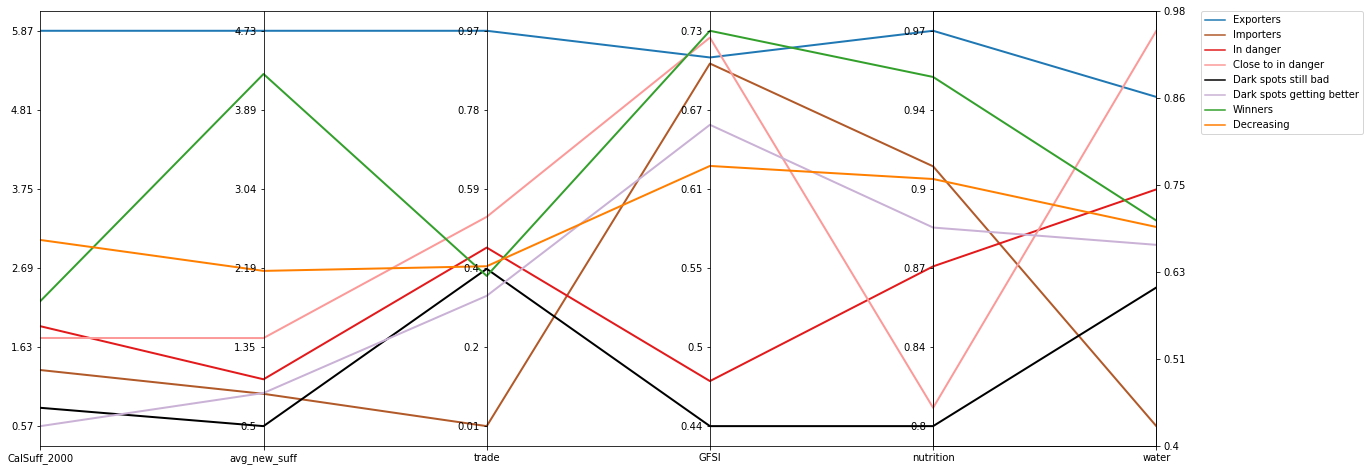

In [507]:
columns = ['CalSuff_2000', 'avg_new_suff', 'trade', 'GFSI','nutrition', 'water', 'Category']
plot_parallel_coord(averaged, columns, 'Category')
plt.savefig('Romain/figures/' + 'related_datasets/' + 'parallel_coord.png', dpi=500)

In [293]:
def plot_parallel_coord_all_countries(data, columns, index):
    cols = columns.copy()
    df = data[cols].copy()
    cols.remove(index)
    x = [i for i, _ in enumerate(cols)]
    
    if len(set(df[index])) > 2:
        colours = palettes.Colorblind[len(set(df[index]))]
    else: 
        colours = ['blue', 'red']
        
    col_index = dict(zip(list(set(df[index])), range(len(set(df[index])))))

    # create dict of categories: colours
    colours = {df.loc[i, index]: colours[col_index[category]] for i, category in enumerate(df[index])}

    # Create (X-1) sublots along x axis
    fig, axes = plt.subplots(1, len(x)-1, sharey=False, figsize=(20, 8))

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for col in cols:
        min_max_range[col] = [df[col].min(), df[col].max(), np.ptp(df[col])]
        df[col] = np.true_divide(df[col] - df[col].min(), np.ptp(df[col]))

    """# Plot each row
    for i, ax in enumerate(axes):
        for idx in df.index:
            category = df.loc[idx, index]
            ax.plot(x, df.loc[idx, cols], colours[category])
        ax.set_xlim([x[i], x[i+1]])"""
    # Plot each category
    for i, ax in enumerate(axes):
        for cat in list(set(df[index])):
            #print(cat, df[df[index] == cat][cols])
            sns.lineplot(x*len(df[df[index] == cat][cols]), df[df[index] == cat][cols].values, color=colours[category], ax=ax)
        ax.set_xlim([x[i], x[i+1]])
    

    # Set the tick positions and labels on y axis for each plot
    # Tick positions based on normalised data
    # Tick labels are based on original data
    def set_ticks_for_axis(dim, ax, ticks):
        min_val, max_val, val_range = min_max_range[cols[dim]]
        step = val_range / float(ticks-1)
        tick_labels = [round(min_val + step * i, 2) for i in range(ticks)]
        norm_min = df[cols[dim]].min()
        norm_range = np.ptp(df[cols[dim]])
        norm_step = norm_range / float(ticks-1)
        ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
        ax.yaxis.set_ticks(ticks)
        ax.set_yticklabels(tick_labels)

    for dim, ax in enumerate(axes):
        ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
        set_ticks_for_axis(dim, ax, ticks=6)
        ax.set_xticklabels([cols[dim]])


    # Move the final axis' ticks to the right-hand side
    ax = plt.twinx(axes[-1])
    dim = len(axes)
    ax.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
    set_ticks_for_axis(dim, ax, ticks=6)
    ax.set_xticklabels([cols[-2], cols[-1]])


    # Remove space between subplots
    plt.subplots_adjust(wspace=0)

    # Add legend to plot
    plt.legend(
        [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in set(df[index])],
        set(df[index]),
        bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

    #plt.title("Values by category")
    plt.show()

Exception: Data must be 1-dimensional

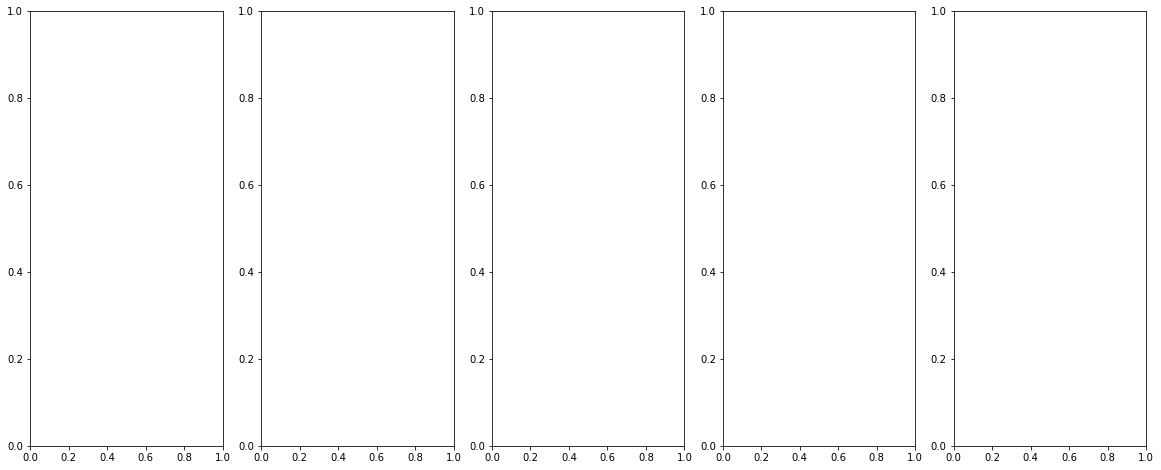

In [294]:
all_countries = sufficiencies.set_index('Category').drop(['Outliers', 'quite variable'] ,).reset_index()


plot_parallel_coord_all_countries(all_countries.dropna().reset_index(drop=True), columns, 'Category')

In [251]:
all_countries[all_countries['Category'] == 'Winners']

,Category,ISO3,CalSuff_2000,ssp1,ssp2,ssp3,ssp4,ssp5,trade,name,GFSI,malnutrition,water,delta_consistency,delta_CalSuff_avg,delta_max,lowest_ssp,avg_new_suff
13,Winners,BLR,4.132729,4.956091,4.959101,4.603134,5.048264,4.923968,0.585432,Belarus,0.657,0.013,NaN,4,0.765383,0.915535,4.603134,4.898112
18,Winners,BWA,1.380435,3.762669,3.882418,22.617275,4.551201,4.661150,0.000000,Botswana,0.608,0.112,0.867710,4,6.514508,21.236840,3.762669,7.894943
36,Winners,EST,3.590247,4.075787,4.478812,4.064219,5.012302,4.245205,0.702297,Estonia,NaN,NaN,NaN,4,0.785018,1.422056,4.064219,4.375265
38,Winners,FIN,2.380448,3.444008,3.685572,3.592001,3.585432,3.784766,0.456939,Finland,0.833,NaN,0.998325,4,1.237908,1.404318,3.444008,3.618356
41,Winners,GEO,1.667451,3.361643,2.763294,2.101617,3.386507,3.564242,0.146300,Georgia,NaN,0.011,0.847210,4,1.368010,1.896792,2.101617,3.035461
66,Winners,LBY,0.389441,2.927622,0.618609,1.146353,0.841398,0.906447,NaN,Libya,NaN,0.056,0.143608,4,0.898644,2.538180,0.618609,1.288086
72,Winners,MDA,2.888517,6.932901,6.150338,2.734554,7.217087,7.742899,0.766164,Moldova,NaN,0.022,0.724868,3,3.267039,4.854382,2.734554,6.155556
79,Winners,MNG,5.247659,10.667547,12.744913,6.064427,10.597284,10.788507,0.331338,Mongolia,NaN,0.016,0.553336,4,4.924876,7.497254,6.064427,10.172536
84,Winners,NAM,1.932915,2.788065,3.812638,9.196102,2.912448,5.316363,0.218579,Namibia,NaN,0.132,0.692996,4,2.872208,7.263187,2.788065,4.805123
89,Winners,NOR,1.011166,1.852471,2.099194,2.519415,2.507514,1.800575,0.000000,Norway,0.822,NaN,0.996101,4,1.144668,1.508249,1.800575,2.155834


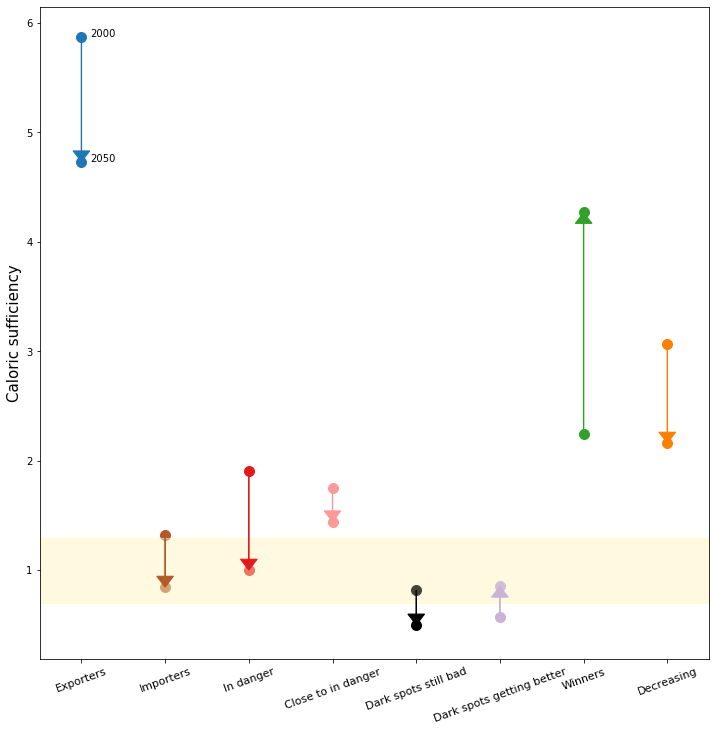

In [514]:
plt.figure(figsize=(12, 12))
plt.xlim(-0.5, len(averaged)-0.5)
plt.xticks(np.arange(len(averaged)), list(averaged['Category'].values), rotation=20, fontsize=11)
plt.ylabel('Caloric sufficiency', fontsize=15)

for i, row in averaged.iterrows():
    colors = color_map
    plt.fill_between([-1, len(averaged)], 0.7, 1.3, color='lemonchiffon', alpha=0.1)
    plt.arrow(i, row['CalSuff_2000'], 0, row['avg_new_suff']-row['CalSuff_2000'], width=0.005, head_width=0.2, head_length=0.1, length_includes_head=True, alpha=1, color=colors[i])
    plt.scatter([i, i], row[['CalSuff_2000', 'avg_new_suff']], marker='o', label=row['Category'], s=100, c=colors[i])
    if i == 0:
        plt.annotate('2000', (i+0.1, row['CalSuff_2000']))
        plt.annotate('2050', (i+0.1, row['avg_new_suff']))
        
plt.savefig('Romain/figures/related_datasets/changes_cal_suff.png', dpi=500)

In [523]:
all_countries.groupby('Category').count()

,ISO3,CalSuff_2000,ssp1,ssp2,ssp3,ssp4,ssp5,trade,name,GFSI,malnutrition,water,delta_consistency,delta_CalSuff_avg,delta_max,lowest_ssp,avg_new_suff
Category,,,,,,,,,,,,,,,,,
Dark spots getting better,5,5,5,5,5,5,5,5,5,3,4,4,5,5,5,5,5
Dark spots still bad,23,23,23,23,23,23,23,19,23,19,22,20,23,23,23,23,23
Exporters,17,17,17,17,17,17,17,17,17,12,11,15,17,17,17,17,17
Importers,23,23,23,23,23,23,23,23,23,12,16,21,23,23,23,23,23
In danger (drop below 1),19,19,19,19,19,19,19,15,19,14,19,16,19,19,19,19,19
Winners,14,14,14,14,14,14,14,13,14,8,8,12,14,14,14,14,14
decreasing,26,26,26,26,26,26,26,24,26,16,19,17,26,26,26,26,26
kinda in danger,4,4,4,4,4,4,4,4,4,3,1,3,4,4,4,4,4


## Country examples

countries:
- dark spot getting better: Morocco
- dark sport still bad: Niger
- exporters: Brazil
- importers: Saudi Arabia or Japan
- in danger: Mozambique
- winners: Tunisia
- decreasing: Germany
- kinda in danger: Myanmar



In [119]:
countries = ['Morocco', 'Niger', 'United States of America', 'Saudi Arabia', 'Mozambique', 'Tunisia', 'Germany', 'Myanmar']

sufficiencies[sufficiencies.name.isin(countries)][['Category', 'CalSuff_2000', 'avg_new_suff']]

,Category,CalSuff_2000,avg_new_suff
38,decreasing,2.351062,2.049898
92,Dark spots getting better,0.511462,0.853802
98,kinda in danger,1.620466,1.324633
101,In danger (drop below 1),0.887487,0.572406
106,Dark spots still bad,0.673067,0.508459
128,Importers,0.630262,0.582931
151,Winners,0.608106,1.343132
158,Exporters,5.525028,3.465227


In [522]:
len(all_countries)

131